# 生成器：按国别生成人名
> 原文：https://docs.pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

本篇笔记用更简洁和现代的 API 重新实现原文的分类器，并提供更好的可读性和更好的性能。

- 在训练和预测时，实现了以前序多个字符预测下一个字符，原文只实现了前一个字符预测下一个字符
- 相对于原文本模型设计有三点改进：

1. 以国别信息作为第一个字符，实现了只需输入国别信息就可以生成对应的名字；
2. 原文并没把国别信息作为字符进行统一编码，而是国别和字符分别编码，再拼接在一起作为输入，导致模型参数偏多；
3. 原文在使用体验也不好，不仅要输入国别信息，还要输入首个字符，才能进行生成。

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

%matplotlib inline

torch.manual_seed(9527)

## 1. 数据理解

`data/names/{nation}.txt` 有多个 txt 文件，文件名为国别标签，文件内容每行为一个名字。现把原始数据按文件读出，初步统计国别、名字及字符规模。

In [2]:
from glob import glob

nation2names, charset = {}, set()

for path in glob("data/names/*.txt"):
    nation = path.split("/")[-1].split(".")[0]
    with open(path, "r", encoding="utf-8") as f:
        names = [name.strip() for name in f.readlines() if name.strip()]
        nation2names[nation] = names
        charset.update(*names)

nations = list(nation2names)
chars = "".join(sorted(charset))

vocab_size = len(nations) + len(chars) + 1  # +1 for the <EOS> character

vocab_size, sum(len(names) for names in nation2names.values())

(106, 20074)

## 2. 模型设计

1. 所有 name 以为国别信息作为第一个字符，并在末尾显式增加结束字符，如 `<English>Abbas<EOS>` 一共 7 个字符
2. 因为国别也是名字的一部分，这样只需输入就可以生成对应国别的名字，在遇到结束字符时停止生成
3. 普通字符、国别字符和结束字符统一 one-hot 编码，总的 `vocab_size` 为 `label_size + chars_size + 1`
4. 每个 name 都会生成一个子数据集用于训练，生成规则是前序字符预测下一个字符，如 `<English>Abbas<EOS>`：
```
         <English> -> A
        <English>A -> b
       <English>Ab -> b
      <English>Abb -> a
     <English>Abba -> s
    <English>Abbas -> <EOS>
```
5. `(L, vocab_size)` -> LSTM -> `(hidden_size)` -> Linear -> `(vocab_size)`


In [3]:
class Generator(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(vocab_size, hidden_size)
        self.line = nn.Linear(hidden_size, vocab_size, bias=False)

    def forward(self, x, hc=None):
        _, (h, _) = self.lstm(x, hc)
        y = self.line(h[-1])
        return y


model = Generator(vocab_size, 128)
model

Generator(
  (lstm): LSTM(106, 128)
  (line): Linear(in_features=128, out_features=106, bias=False)
)

## 3. 数据准备

1. 实现 name one hot 编码，编号顺序是 nations, <EOS>, chars
2. 实现 Dataset 和 DataLoader, batch_size 为 64

In [4]:

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

def one_hot_encode(nation, name):
    indices = [
        nations.index(nation),
        *(chars.find(c) + len(nations) + 1 for c in name),
        len(nations),
    ]
    return F.one_hot(torch.tensor(indices), vocab_size).float()


def one_hot_decode(x):
    return "".join(chars[i - len(nations) - 1] for i in x.argmax(dim=-1).tolist())


class Dataset(Dataset):
    def __init__(self, nation2names):
        self.data = []
        for nation, names in nation2names.items():
            for name in names:
                x = one_hot_encode(nation, name)
                for i in range(1, len(x)):
                    self.data.append((x[:i], x[i].argmax()))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


batch_size, dataset = 64, Dataset(nation2names)

dataloader = DataLoader(dataset, batch_size, shuffle=True, collate_fn=lambda x: x)

for batch in dataloader:
    for x, y in batch:
        print(x.shape, y)
        break
    break

torch.Size([8, 106]) tensor(56)


## 4. 模型训练

1. 损失函数用 nn.CrossEntropyLoss
2. 优化器用 optim.Adam

Epoch  1/5, Loss: 2.5319938108359956
Epoch  2/5, Loss: 2.1516759950169555
Epoch  3/5, Loss: 2.019211669980408
Epoch  4/5, Loss: 1.9305134815476293
Epoch  5/5, Loss: 1.8673972754016157


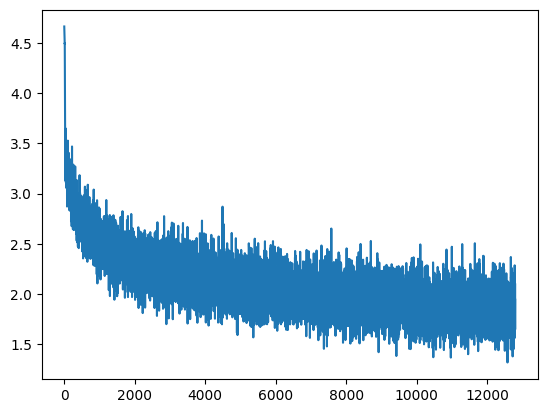

In [5]:
import torch.optim as optim

def train(model, dataloader, epochs=5, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn, losses = nn.CrossEntropyLoss(), []
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            outputs, targets = [], []
            for x, y in batch:
                output = model(x)
                outputs.append(output)
                targets.append(y)

            outputs = torch.stack(outputs)
            targets = torch.stack(targets)
            loss = loss_fn(outputs, targets)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss = loss.item()
            losses.append(loss)
            total_loss += loss
        print(f"Epoch {epoch+1:>2}/{epochs}, Loss: {total_loss / len(dataloader)}")
    return losses


losses = train(model, dataloader)

plt.figure()
plt.plot(losses)
plt.show()

## 5. 模型验证

In [6]:
@torch.no_grad()
def generate(model, nation):
    model.eval()
    index = nations.index(nation)
    y = torch.tensor([]).float().view(0, vocab_size)
    while True:
        x = torch.zeros(1, vocab_size).float()
        x[0, index] = 1.0
        y = torch.cat((y, x), dim=0)
        index = model(y).softmax(dim=0).multinomial(1).item()
        if index <= len(nations):
            break
    return y[1:]


for nation in nations:
    print(
        f"{nation:>10}: {", ".join(
            one_hot_decode(generate(model, nation)) for _ in range(5)
        )}"
    )

     Czech: Bzhulein, Mcdeel, Hantick, Hormanek, Scheak
    German: Ormarts, Selech, Frookel, BacjerEgh, Kwohpe
    Arabic: Perneb, Bata, Kussah, Kahain, Hakali
  Japanese: Maruma, Kesei, Ohama, Ishijowa, Kusi
   Chinese: Ei, Yan, Paoe, Win, Yue
Vietnamese: Deu, Gang, Shuoug, Awumn, Vku
   Russian: Hafaevsky, Glopaeits, Jarujin, Hrigoretsykov, Vijtoe
    French: Licgaufent, Caur, Juveald, Lexuet, Gandior
     Irish: Rigur, Alenohmighuls, MalLon, Laghgad, Chaudliloghnoan
   English: Loughli, Buarev, Shurmowa, Mchoy, Haar
   Spanish: Camro, Uentinusoiel, Luzvelur, Artofi, Capurar
     Greek: Atrisatara, Hraspa, Rerrazis, Develona, Arves
   Italian: Dromonya, Amawa, Coldere, ilribo, Racte
Portuguese: Salotora, Dagino, Miraces, Arealanoi, Tramidr
  Scottish: Tofner, Weltritt, Alenair, Liccier, Noush
     Dutch: Couet, Borz, Molfers, Kanr, Reamjewsons
    Korean: Ue, Mveng, Cheng, Toa-, Ching
    Polish: Nydachki, Protovayjchik, Stúrske, Stark, Domarez
